# IMDB exploratory data analysis to isolate factors which contribute most to movie profitability or popularity

In [ ]:
#need to make a table that has the top 33% of movies by popularity, with ratings over 7.0, and actors/actresses in the cast
#need to include the actor/actress name, movie name, rating, profit, and popularity
#adjust as needed
cte_mega_string = """
-- Drop the temporary table if it already exists
IF OBJECT_ID('tempdb..#topmovies2000') IS NOT NULL
    DROP TABLE #topmovies2000;

WITH FilteredRatings AS (
    SELECT tconst, averageRating, numVotes
    FROM dbo.ratings
    WHERE averageRating > 7.0
),
--break list by popularity into n-tile
FilteredPopularity AS (
    Select
        imdb_id,
        popularity,
        genres,
        overview,
        ProductionCompanies,
        NTILE(3) OVER (ORDER BY popularity DESC) AS popularity_percentile 
    from dbo.meta
),
FilteredBasics AS (
    SELECT tconst, primaryTitle, startYear, runtimeMinutes
    FROM dbo.basics
    WHERE startYear >= 2000
),
Budget AS (
    SELECT imdb_id, budget, (revenue - budget) AS profit
    FROM dbo.meta
)
SELECT DISTINCT
    cast.tconst, -- movie number unique id
    base.primaryTitle, --movie name
    cast.category,
    rates.averageRating, -- ratings
    nam.primaryName AS actor_name,
    budget.budget,
    budget.profit,
    pop.popularity,
    pop.genres,
    pop.ProductionCompanies,
    pop.overview

FROM dbo.principals AS cast
JOIN FilteredBasics AS base ON base.tconst = cast.tconst
JOIN FilteredRatings AS rates ON rates.tconst = cast.tconst
JOIN budget on budget.imdb_id = cast.tconst
JOIN dbo.name AS nam ON nam.nconst = cast.nconst
JOIN FilteredPopularity AS pop ON pop.imdb_id = cast.tconst
WHERE cast.category IN ('actor', 'actress')
    AND pop.popularity_percentile = 1
ORDER BY pop.popularity DESC;
"""


In [ ]:
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
# connection details
server = 'sourcetoshare.database.windows.net'
database = 'imdb'
username = 'jeffrey'
password = 'PASSWORD####'
driver = 'ODBC Driver 17 for SQL Server'


# Create the connection string in SQLAlchemy format
conn_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver.replace(" ", "+")}'

# Create the SQLAlchemy engine
engine = create_engine(conn_string)
# Execute the query and load the data into a pandas DataFrame
cte_df = pd.read_sql(cte_mega_string, conn_string)

# Display the first few rows of the dataframe
print(cte_df.head())

In [ ]:
# first we need to clean up the data
# 1. remove empties
cte_df = cte_df.dropna()
# 2. remove entries with budgets of zero
cte_df = cte_df[cte_df['budget'] != 0]
#Creates a new binary column for each unique actor name. 
dummies_df = pd.get_dummies(cte_df, columns=['actor_name'])
dummies_df.head(n=5)


In [ ]:
# We'll start easy by just using the profit and popularity columns
correlation = dummies_df[['profit', 'popularity']].corr()
print(correlation)

In [ ]:
# Now we'll use all the actor columns and the popularity column, since we're interested in the relationship between the actors and the popularity of the movie
# We'll select all columns that start with 'actor_'
#since there are a ton of names we'll use a loop to create a bunch of columns
selected_columns = ['popularity'] + [col for col in dummies_df.columns if col.startswith('actor_')]
print(selected_columns[0:10])

In [ ]:
# Create a new dataframe with only the selected columns
new_df = dummies_df[selected_columns]

# Calculate the correlation matrix
pop_matrix = new_df.corr()

# remove the 100 correlation with itself
pop_matrix = pop_matrix.drop('popularity')

# Remove the 'actor_' prefix from the index
pop_matrix.index = pop_matrix.index.str.replace('actor_name_', '')

# Display the correlation matrix
pop_matrix= pop_matrix['popularity'].sort_values(ascending=False)

print(pop_matrix)

# Correlation results for popularity and actors
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the popularity of the movie.

In [ ]:
# Now we'll use all the actor columns and the  column, since we're interested in the relationship between the actors and the profit of the movie
selected_columns = ['profit'] + [col for col in dummies_df.columns if col.startswith('actor_')]


# Create a new dataframe with only the selected columns
new_df = dummies_df[selected_columns]

# Calculate the correlation matrix
profit_matrix = new_df.corr()

# remove the 100 correlation with itself
profit_matrix = profit_matrix.drop('profit')


# Remove the 'actor_' prefix from the index
profit_matrix = profit_matrix['profit'].sort_values(ascending=False)
profit_matrix.index = profit_matrix.index.str.replace('actor_name_', '')

# Display the correlation matrix
print(profit_matrix)

# Correlation result for profit and actors:
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the profit of the movie.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the correlation matrixa Keep only the top 10 and bottom 10 correlations
top_10 = pop_matrix.head(10)
bottom_10 = pop_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Popularity')
plt.ylabel('Main Actor/Actress')
plt.title('Correlation of Actor Presence with Movie Popularity')
plt.show()

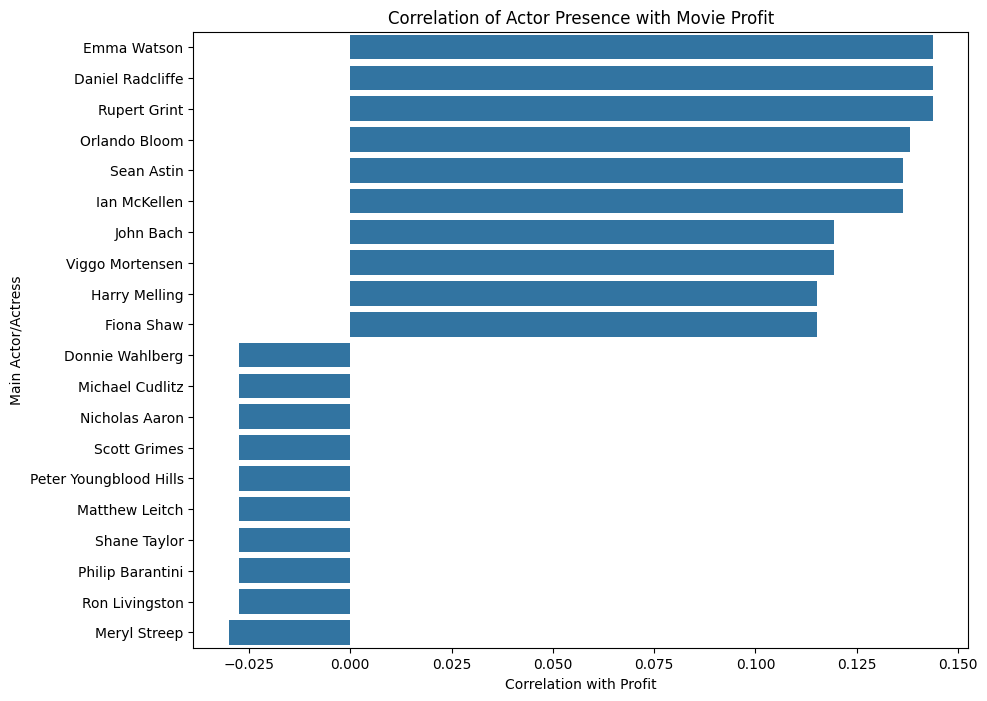

In [38]:

# Calculate the correlation  Keep only the top 10 and bottom 10 correlations
top_10 = profit_matrix.head(10)
bottom_10 = profit_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Profit')
plt.ylabel('Main Actor/Actress')
plt.title('Correlation of Actor Presence with Movie Profit')
plt.show()

 # I found this odd. Anyone see something I am doing wrong? I will do a random forrest now to see which factor contributes the most to popularity and profit. That will also to rank them. I thought for sure this star-power would matter more than this, but perhaps when I compare it to the other variables which may influence popularity or profit, star-power may yet be at the top.
 # I realized after talking with Derrick that I can't form a correlation with a list of names even if I matrix them. So this isn't correlating what I think it is. It isn't doing anything meaningful. I feel dumb... moving on.


In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# We assign a target for the random forest model:
target_column = 'profit'

# Create a new data frame suitable for the random forest model
# shallow copy: dataframe copy() method, to make sure we don't alter the original data
rand_forrest_df = cte_df.copy()

# try to drop columns which are not useful espcially if they are strings
for col in rand_forrest_df.columns: #iterate through all columns
    if rand_forrest_df[col].dtype == 'object': # if the column is a string

        # then drop the column if it is not actor name genres or production companies
        if col not in ['actor_name', 'genres', 'ProductionCompanies']: 
            rand_forrest_df.drop(columns=[col], inplace=True)

print(rand_forrest_df.columns)
print(rand_forrest_df.head())

Index(['averageRating', 'actor_name', 'budget', 'profit', 'popularity',
       'genres', 'ProductionCompanies'],
      dtype='object')
   averageRating  ...                                ProductionCompanies
0            9.0  ...  DC Comics, Legendary Pictures, Warner Bros., D...
1            9.0  ...  DC Comics, Legendary Pictures, Warner Bros., D...
2            9.0  ...  DC Comics, Legendary Pictures, Warner Bros., D...
3            9.0  ...  DC Comics, Legendary Pictures, Warner Bros., D...
4            9.0  ...  DC Comics, Legendary Pictures, Warner Bros., D...

[5 rows x 7 columns]


In [ ]:

# Separate features and target (profit)

features = rand_forrest_df.drop(columns=[target_column])
target = rand_forrest_df[target_column]

# One-hot encode the categorical features (actor names, genres, production companies...)

for column in features.select_dtypes(include=['object']).columns:
    # Encode, append in place
    features = pd.concat([features, pd.get_dummies(features[column], prefix=column)], axis=1) 
    features.drop(column, axis=1, inplace=True) #drop the original column

print(features.head())


In [ ]:

# Split into training and testing data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
# initialize the random forest model
Rand_for = RandomForestRegressor(n_estimators=100, random_state=42)
# train the model


#Choosing a learning model 
# Let's use the 